In [32]:
import numpy as np
import pandas as pd
import scipy
import matplotlib.pyplot as plt 
from pyMCDS import pyMCDS
from scipy.integrate import odeint

In [33]:
mcds = pyMCDS('output00000003.xml', 
              'C:\\Users\zeXal\Desktop\stem_cells-master-1\stem_cells-master\output_death_rate_002')

In [34]:
# cell type
all_type= mcds.data['discrete_cells']['cell_type']
print('cell number is : {}'.format(all_type.size))
print('First ten cell types are : {}'.format(all_type[0:10]))

cell number is : 2017
First ten cell types are : [1. 1. 1. 1. 1. 1. 1. 1. 1. 1.]


In [35]:
# cell cyle type
cycle_models = mcds.data['discrete_cells']['cycle_model']
print('cell number is : {}'.format(cycle_models.size))
print('first ten members are {}'.format(cycle_models[0:10]))

cell number is : 2017
first ten members are [100.   5.   5.   5. 100.   5. 100. 100.   5.   5.]


In [36]:
number_of_cells = all_type.size
live1_count = 0
live2_count = 0
for n in range(number_of_cells):
    cell_type = np.int( all_type[n] )
    cycle_model = np.int( cycle_models[n] )
    
    # cylce_model = 100 is dead cell
    if(cell_type==1 and cycle_model!=100):
        live1_count +=1
    if(cell_type==2 and cycle_model!=100):
        live2_count +=1
dead_cell = number_of_cells-live1_count-live2_count
print (' Total cell number is:  {} \r \n Type1 cell number is:  {} \r \n Type2 cell number is:  {} \r \n Death cell number is:  {}'.format(number_of_cells,live1_count,live2_count,dead_cell))

 
 
 
 Death cell number is:  1291


In [37]:
def count_live_cells(mcds):
    all_type= mcds.data['discrete_cells']['cell_type']
    cycle_models = mcds.data['discrete_cells']['cycle_model']
    number_of_cells = all_type.size
    live1_count = 0
    live2_count = 0
    for n in range(number_of_cells):
        cell_type = np.int( all_type[n] )
        cycle_model = np.int( cycle_models[n] )
    
    # cylce_model = 100 is dead cell
        if(cell_type==1 and cycle_model!=100):
            live1_count +=1
        if(cell_type==2 and cycle_model!=100):
            live2_count +=1
    dead_cell = number_of_cells-live1_count-live2_count
    return live1_count,live2_count

In [38]:
def solv_ode45_normal(z0,t_total):
    # z0 is the column vector of initial condition 
    
    # time points
    t = np.linspace(0,t_total,np.floor(t_total/1440*10000))
     # solve ODE
    z = odeint(model,z0,t)  
    return z[:,0],z[:,1],t

In [39]:
def apply_radio_therapy(x,y,d):
    # z is the matrix of solution to the ode
    x = x[-1]
    y = y[-1]
    x = x*np.exp(-alpha1*d-beta1*(d**2))+c0*d*y
    y = y*np.exp(-alpha2*d-beta2*(d**2))-c0*d*y
    z = [x,y]
    return z

In [40]:
def one_thearpy(u_lst,v_lst,t_elpse):
    z0  = apply_radio_therapy(u_lst,v_lst,d)
    u_lst[-1] = z0[0]
    v_lst[-1] = z0[1]
    return u_lst,v_lst,t_elpse

In [41]:
def one_growth(u_lst,v_lst,t_elpse,t_mean):
    z0 =[u_lst[-1],v_lst[-1]]
    xl,yl,t = solv_ode45_normal(z0,t_mean)
    t_elpse += t_mean
    u_lst = np.append(u_lst,xl)
    v_lst = np.append(v_lst,yl)
    return u_lst,v_lst,t_elpse

In [42]:
def model(z,t):
    dxdt =   v*z[0]*(2*p-1)
    dydt = 2*v*z[0]*(1-p)  + v*z[1]
    dzdt = [dxdt,dydt]
    return dzdt

In [43]:
def plot_ode45(xl,yl,t):
    # plot results
    plt.plot(t,xl,'b-',label=r'CSC ode')
    plt.plot(t,yl,'r-',label=r'DCC ode')
    plt.plot(t,xl+yl,'g-',label=r'total ode')
    plt.ylabel('cell number')
    plt.xlabel('time')
    plt.legend(loc='best')

In [44]:
v = 1/60/60 # division rate per min
p = 0.8 # probabilty stays stem cell after division
t_total = 14400 # time min
alpha1 = 0.2
beta1  = 0.05
alpha2 = 0.2
beta2  = 0.05
c0     = 0

In [45]:
z0 = [20000,0]
d  = 1 # dose
t_before_thearpy = 12*60 # start 12 hours untreated
t_after_thearpy = 6*60 # last 6 hours after thearpy
t_elpse = 0
u_lst = []
v_lst = []
# solve ODE
xl,yl,t = solv_ode45_normal(z0,t_before_thearpy)
t_elpse += t_before_thearpy
u_lst = np.append(u_lst,xl)
v_lst = np.append(v_lst,yl)
u_lst,v_lst,t_elpse = one_thearpy(u_lst,v_lst,t_elpse)
u_lst,v_lst,t_elpse = one_growth(u_lst,v_lst,t_elpse,t_after_thearpy)
print('total final is around {}'.format(u_lst[-1]+v_lst[-1]))
# plot_ode45(u_lst,v_lst,t = np.linspace(0,t_elpse,len(u_lst)))

total final is around 21025.421933744816


C:\Users\zeXal\Anaconda3\lib\site-packages\ipykernel_launcher.py:5: DeprecationWarning: object of type <class 'numpy.float64'> cannot be safely interpreted as an integer.
  """


In [46]:
def get_data(directory,first_index, increment, last_index):
    number_of_files = np.int( np.floor( (last_index-first_index)/increment)+1);
    type1_matrix = np.zeros(number_of_files)
    type2_matrix = np.zeros(number_of_files)
    time_matrix  = np.zeros(number_of_files)
    for i in range( first_index, last_index+1 , increment ):
        # use python version of sprintf( 'output%08i.xml', i )
        new_str = "output%08d.xml" % i
        mcds = pyMCDS(new_str,directory)
        live1, live2 = count_live_cells( mcds )
        type1_matrix[i] = live1
        type2_matrix[i] = live2
        time_matrix[i]  = mcds.get_time()
    return type1_matrix,type2_matrix,time_matrix

In [47]:
direc_lst    = 'C:\\Users\zeXal\Desktop\stem_cells-master-1_20000\stem_cells-master\output'
type1_matrix,type2_matrix,time_matrix=get_data(direc_lst,0,1,108)

In [48]:
def plot_data(type1_matrix,type2_matrix,time_matrix):
    plt.plot(time_matrix,type1_matrix,'bo',label='CSC simulation')
    plt.plot(time_matrix,type2_matrix,'ro',label='DCC simulation')
    plt.plot(time_matrix,type2_matrix+type1_matrix,'go',label='total simulation')
    plt.legend()

(0, 25000)

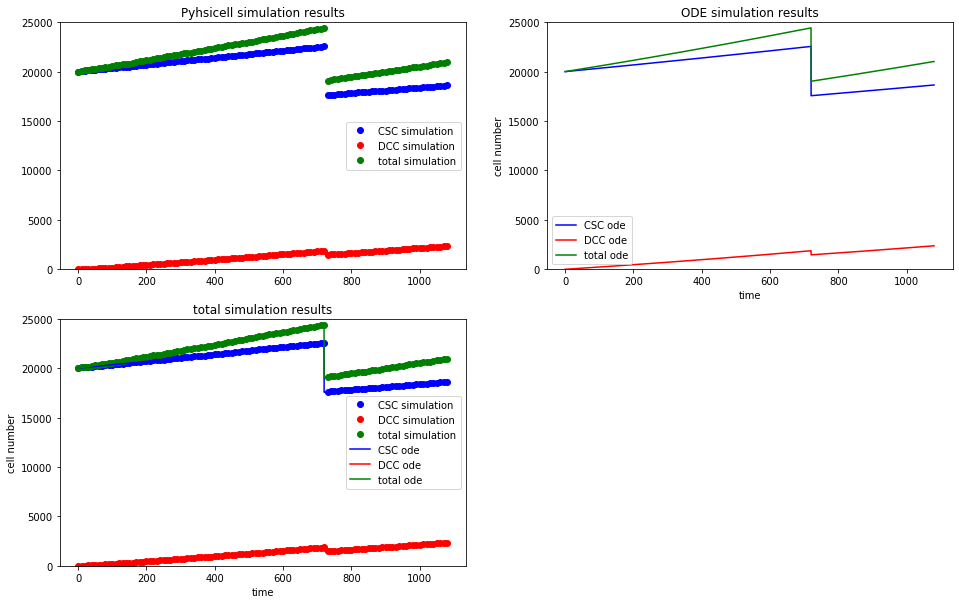

In [49]:
plt.figure(figsize=(16,10))
plt.subplot(2,2,1)
plot_data(type1_matrix,type2_matrix,time_matrix)
plt.title('Pyhsicell simulation results')
plt.ylim(0,25000)
plt.subplot(2,2,2)
plot_ode45(u_lst,v_lst,t = np.linspace(0,t_elpse,len(u_lst)))
plt.title('ODE simulation results')
plt.ylim(0,25000)
plt.subplot(2,2,3)
plot_data(type1_matrix,type2_matrix,time_matrix)
plot_ode45(u_lst,v_lst,t = np.linspace(0,t_elpse,len(u_lst)))
plt.title('total simulation results')
plt.ylim(0,25000)

In [50]:
ode_before_theartpy_u= u_lst[np.int(np.floor(len(u_lst)*2/3)-2)]
ode_after_theartpy_u = u_lst[np.int(np.floor(len(u_lst)*2/3+1))]
ode_end_value_u      = u_lst[-1]
ode_u_survive_rate      = 1/(ode_before_theartpy_u/ode_after_theartpy_u)

ode_before_theartpy_v= v_lst[np.int(np.floor(len(u_lst)*2/3)-2)]
ode_after_theartpy_v = v_lst[np.int(np.floor(len(u_lst)*2/3+1))]
ode_end_value_v      = v_lst[-1]
ode_v_survive_rate      = 1/(ode_before_theartpy_v/ode_after_theartpy_v)

ode_before_theartpy_total= ode_before_theartpy_u + ode_before_theartpy_v
ode_after_theartpy_total = ode_after_theartpy_u + ode_after_theartpy_v
ode_end_value_total      = ode_end_value_u + ode_end_value_v
ode_total_survive_rate      = 1/(ode_before_theartpy_total/ode_after_theartpy_total)

In [51]:
simulation_before_thearpy_u = type1_matrix[np.int(np.floor(len(type1_matrix)*2/3))]
simulation_after_thearpy_u  = type1_matrix[np.int(np.floor(len(type1_matrix)*2/3+1))]
simulation_end_value_u      = type1_matrix[-1]
simulation_u_survive        = 1/(simulation_before_thearpy_u/simulation_after_thearpy_u)

simulation_before_thearpy_v = type2_matrix[np.int(np.floor(len(type1_matrix)*2/3))]
simulation_after_thearpy_v  = type2_matrix[np.int(np.floor(len(type1_matrix)*2/3+1))]
simulation_end_value_v      = type2_matrix[-1]
simulation_v_survive        = 1/(simulation_before_thearpy_v/simulation_after_thearpy_v)

simulation_before_thearpy_total = simulation_before_thearpy_u +simulation_end_value_v
simulation_after_thearpy_total  = simulation_after_thearpy_u + simulation_after_thearpy_v
simulation_end_value_total      = simulation_end_value_u + simulation_end_value_v
simulation_total_survive        = 1/(simulation_before_thearpy_total/simulation_after_thearpy_total)

In [52]:
import pandas as pd
data = [[ode_before_theartpy_u, ode_after_theartpy_u,ode_u_survive_rate,ode_end_value_u],
        [simulation_before_thearpy_u, simulation_after_thearpy_u,simulation_u_survive,simulation_end_value_u],
        [ode_before_theartpy_v, ode_after_theartpy_v,ode_v_survive_rate,ode_end_value_v],
        [simulation_before_thearpy_v, simulation_after_thearpy_v,simulation_v_survive,simulation_end_value_v],
        [ode_before_theartpy_total, ode_after_theartpy_total,ode_total_survive_rate,ode_end_value_total],
       [simulation_before_thearpy_total, simulation_after_thearpy_total,simulation_total_survive,simulation_end_value_total]]

df = pd.DataFrame(data, columns=[ "Before Thearpy","After Thearpy","Survival Rate","End Value"])
s = pd.Series(['ODE result CSC',  'simulation CSC','ODE result DCC', 'simulation DCC','ODE result Total',  'simulation Total'])
df.set_index([s])

,Before Thearpy,After Thearpy,Survival Rate,End Value
ODE result CSC,22549.395731,17562.330278,0.778838,18647.876398
simulation CSC,22550.000000,17627.000000,0.781685,18598.000000
ODE result DCC,1877.682137,1463.019518,0.779163,2377.545535
simulation DCC,1854.000000,1473.000000,0.794498,2343.000000
ODE result Total,24427.077869,19025.349796,0.778863,21025.421934
simulation Total,24893.000000,19100.000000,0.767284,20941.000000


In [53]:
d = 1
print(d^2)

3


In [54]:
def model_feedback(z,t):
    # z0 is the column vector of initial condition 
    dxdt =   (v/(1+h*z[2]**k))*z[0]*(2*(p/(1+l*z[2]**n))-1)
    dydt = 2*(v/(1+h*z[2]**k))*z[0]*(1-(p/(1+l*z[2]**n)))    + (v/(1+h*z[2]**k))*z[1]
    dcdt =                                                   factor_release_rate*z[1]
    dzdt = [dxdt,dydt,dcdt]
    return dzdt

In [55]:
def model_feedback1(z,t):
    # z0 is the column vector of initial condition 
    dxdt =   (v/(1+h*z[2]**k))*z[0]*(2*p-1)
    dydt = 2*(v/(1+h*z[2]**k))*z[0]*(1-p)    + (v/(1+h*z[2]**k))*z[1]
    dcdt =                                   factor_release_rate*z[1]
    dzdt = [dxdt,dydt,dcdt]
    return dzdt

In [56]:
def solv_ode45_feedback(z0,t_total):
    # z0 is the column vector of initial condition 
    
    # time points
    t = np.linspace(0,t_total,np.floor(t_total/1440*10000))
     # solve ODE
    z = odeint(model_feedback1,z0,t)  
    return z[:,0],z[:,1],z[-1,2],t

In [57]:
z0 = [10000,0,0]
factor_release_rate = 0.01 # 0.0000001
h  = 1
k  = 1
l  = 1
n  = 1
d  = 1 # dose
t_before_thearpy = 18*60 # start 12 hours untreated
t_elpse = 0
u_lst = []
v_lst = []
# solve ODE
xl,yl,cl,t = solv_ode45_feedback(z0,t_before_thearpy)
t_elpse += t_before_thearpy
u_lst = np.append(u_lst,xl)
v_lst = np.append(v_lst,yl)
print('total final cell is around {}, factor C is {}'.format(u_lst[-1]+v_lst[-1],cl))

total final cell is around 10090.324331959471, factor C is 346.05479273369747


C:\Users\zeXal\Anaconda3\lib\site-packages\ipykernel_launcher.py:5: DeprecationWarning: object of type <class 'numpy.float64'> cannot be safely interpreted as an integer.
  """


In [58]:
direc_lst    = 'C:\\Users\zeXal\Desktop\stem_cells-master-1\stem_cells-master\output_feedback00000001'
type1_matrix,type2_matrix,time_matrix=get_data(direc_lst,0,1,18)

(0, 25000)

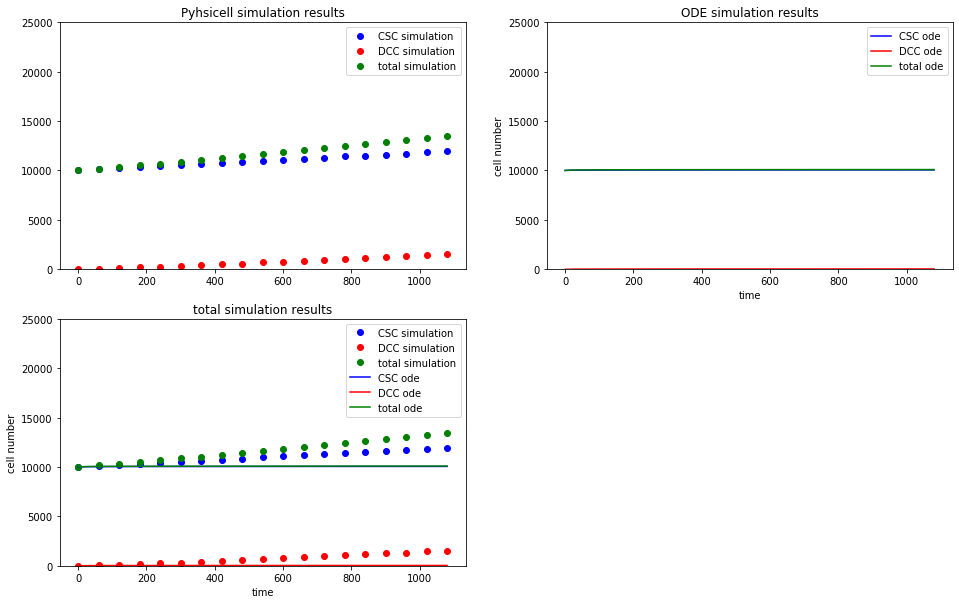

In [59]:
plt.figure(figsize=(16,10))
plt.subplot(2,2,1)
plot_data(type1_matrix,type2_matrix,time_matrix)
plt.title('Pyhsicell simulation results')
plt.ylim(0,25000)
plt.subplot(2,2,2)
plot_ode45(u_lst,v_lst,t = np.linspace(0,t_elpse,len(u_lst)))
plt.title('ODE simulation results')
plt.ylim(0,25000)
plt.subplot(2,2,3)
plot_data(type1_matrix,type2_matrix,time_matrix)
plot_ode45(u_lst,v_lst,t = np.linspace(0,t_elpse,len(u_lst)))
plt.title('total simulation results')
plt.ylim(0,25000)

In [60]:
z0 = [10000,0,0]
factor_release_rate = 0.01 # 0.0000001
h  = 1
k  = 1
l  = 1
n  = 1
d  = 1 # dose
t_before_thearpy = 18*60 # start 12 hours untreated
t_elpse = 0
u_lst = []
v_lst = []
# solve ODE
xl,yl,cl,t = solv_ode45_feedback(z0,t_before_thearpy)
t_elpse += t_before_thearpy
u_lst = np.append(u_lst,xl)
v_lst = np.append(v_lst,yl)
print('total final cell is around {}, factor C is {}'.format(u_lst[-1]+v_lst[-1],cl))

total final cell is around 10090.324331959471, factor C is 346.05479273369747


C:\Users\zeXal\Anaconda3\lib\site-packages\ipykernel_launcher.py:5: DeprecationWarning: object of type <class 'numpy.float64'> cannot be safely interpreted as an integer.
  """


(0, 25000)

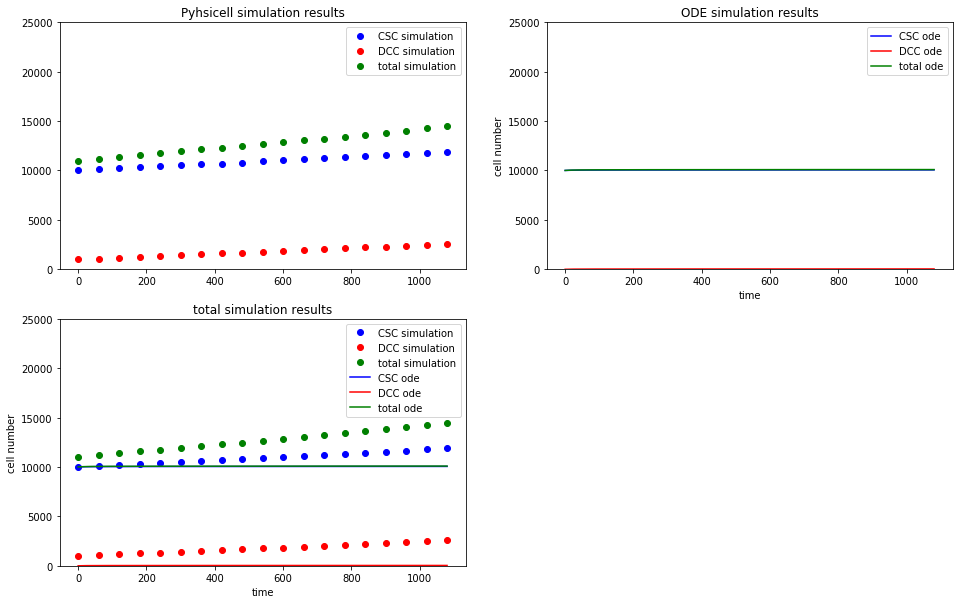

In [61]:
direc_lst    = 'C:\\Users\zeXal\Desktop\stem_cells-master-1\stem_cells-master\output'
type1_matrix,type2_matrix,time_matrix=get_data(direc_lst,0,1,18)

plt.figure(figsize=(16,10))
plt.subplot(2,2,1)
plot_data(type1_matrix,type2_matrix,time_matrix)
plt.title('Pyhsicell simulation results')
plt.ylim(0,25000)
plt.subplot(2,2,2)
plot_ode45(u_lst,v_lst,t = np.linspace(0,t_elpse,len(u_lst)))
plt.title('ODE simulation results')
plt.ylim(0,25000)
plt.subplot(2,2,3)
plot_data(type1_matrix,type2_matrix,time_matrix)
plot_ode45(u_lst,v_lst,t = np.linspace(0,t_elpse,len(u_lst)))
plt.title('total simulation results')
plt.ylim(0,25000)

In [62]:
def get_micro(directory,first_index, increment, last_index):
    number_of_files = np.int( np.floor( (last_index-first_index)/increment)+1);
    fctorC_matrix = np.zeros(number_of_files)
    for i in range( first_index, last_index+1 , increment ):
        # use python version of sprintf( 'output%08i.xml', i )
        new_str = "output%08d.xml" % i
        mcds = pyMCDS(new_str,directory)
        factorC_matrix[i] = mcds.data['continuum_variables']['factorC']
    return type1_matrix,type2_matrix,time_matrix

In [63]:
directory    = 'C:\\Users\zeXal\Desktop\stem_cells-master-1\stem_cells-master\output'
new_str = "output%08d.xml" % 12
mcds = pyMCDS(new_str,directory)
fac_con = mcds.get_concentrations('factorC')

In [64]:
np.where(fac_con!=0)

(array([ 14,  14,  14, ..., 134, 135, 135], dtype=int64),
 array([ 20,  26,  88, ..., 127,  72,  73], dtype=int64),
 array([0, 0, 0, ..., 0, 0, 0], dtype=int64))

In [65]:
fac_x = np.where(fac_con!=0)[0]
fac_x.shape

(2353,)

In [66]:
sum(sum(fac_con))

array([1473.6435009])

In [67]:
fac_con.shape

(150, 150, 1)

In [68]:
150**2

22500